In [39]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


CPU times: user 205 ms, sys: 16.7 ms, total: 222 ms
Wall time: 220 ms


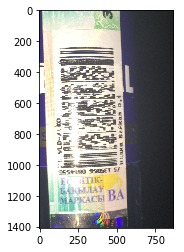

In [3]:
%%time

excise_src = cv2.imread("data/premasked/IMG_0625.JPG")
cropped = excise_src[880:880+1408, 828:828+868]
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

## Typycal thresholding (typycal for us)

In [11]:
def build_segmentation_row(filesconut, current_file_index, fig, input_src, barcode, contoured_barcode):
    
    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(barcode, cv2.COLOR_BGR2RGB))
    a.set_title('Barcode')
    
    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(contoured_barcode, cv2.COLOR_GRAY2RGB))
    a.set_title('Selected Barcode')

CPU times: user 127 ms, sys: 1.06 ms, total: 128 ms
Wall time: 71.2 ms


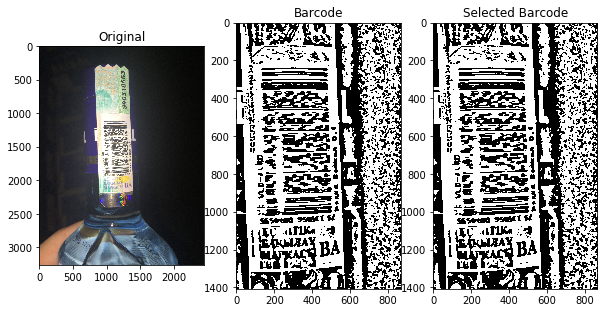

In [5]:
def excise_segmentation(image):
    
    barcode = image[880:880+1408, 828:828+868]
   
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
 
    # Barcode
    hsv_image = cv2.cvtColor(barcode, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    barcode_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
 
    # return the segmentationed images
    # return serial_thresholded, number_thresholded, barcode_thresholded
    return barcode_thresholded

# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0625.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0560.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
filescount = 1
current_file_index = 0
fig = plt.figure(figsize=(10, 200))
%time barcode_thresholded = excise_segmentation(excise_src)
build_segmentation_row(filescount, current_file_index, fig, excise_src, barcode_thresholded, barcode_thresholded)
plt.show()

### Specular highlights prevents us to recognise barcode

Try to impaint over Specular

In [15]:
def derive_m(img, rimg):
    ''' Derive m (intensity) based on paper formula '''

    (rw, cl, ch) = img.shape
    for r in range(rw):
        for c in range(cl):
            rimg[r,c] = int(np.sum(img[r,c])/3.0)
            
    return rimg

def derive_saturation(img, rimg):
    ''' Derive staturation value for a pixel based on paper formula '''

    s_img = np.array(rimg)
    (r, c) = s_img.shape
    for ri in range(r):
        for ci in range(c):
            #opencv ==> b,g,r order
            s1 = img[ri,ci][0] + img[ri,ci][2]
            s2 = 2 * img[ri,ci][1] 
            if  s1 >=  s2:
                s_img[ri,ci] = 1.5*(img[ri,ci][2] - rimg[ri,ci])
            else:
                s_img[ri,ci] = 1.5*(rimg[ri,ci] - img[ri,ci][0])

    return s_img

def check_pixel_specularity(mimg, simg):
    ''' Check whether a pixel is part of specular region or not'''

    m_max = np.max(mimg) * 0.8
    s_max = np.max(simg) * 0.33

    (rw, cl) = simg.shape

    spec_mask = np.zeros((rw,cl), dtype=np.uint8)
    for r in range(rw):
        for c in range(cl):
            if mimg[r,c] >= m_max and simg[r,c] <= s_max:
                spec_mask[r,c] = 255
    
    return spec_mask

def enlarge_specularity(spec_mask):
    ''' Use sliding window technique to enlarge specularity
        simply move window over the image if specular pixel detected
        mark center pixel is specular
        win_size = 3x3, step_size = 1
    '''

    win_size, step_size = (3,3), 1
    enlarged_spec = np.array(spec_mask)
    for r in range(0, spec_mask.shape[0], step_size):
        for c in range(0, spec_mask.shape[1], step_size):
            # yield the current window
            win = spec_mask[r:r + win_size[1], c:c + win_size[0]]
            
            if win.shape[0] == win_size[0] and win.shape[1] == win_size[1]:
                if win[1,1] !=0:
                    enlarged_spec[r:r + win_size[1], c:c + win_size[0]] = 255 * np.ones((3,3), dtype=np.uint8)

    return enlarged_spec 

/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ubyte_scalars
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in ubyte_scalars


CPU times: user 59.5 s, sys: 3.97 ms, total: 59.5 s
Wall time: 59.5 s


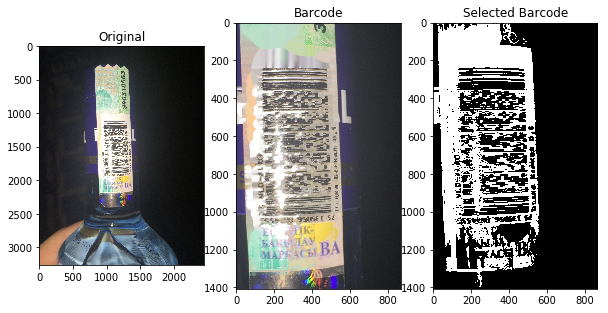

In [17]:
def excise_segmentation(image):
    
    barcode = image[880:880+1408, 828:828+868]
    
    r_img = m_img = np.array(cv2.cvtColor(barcode, cv2.COLOR_BGR2GRAY))
    
    rimg = derive_m(barcode, r_img)
    s_img = derive_saturation(barcode, rimg)
    spec_mask = check_pixel_specularity(rimg, s_img)
    # enlarged_spec = enlarge_specularity(spec_mask)

    # use opencv's inpaint methods to remove specularity
    radius = 12 
    telea = cv2.inpaint(barcode, spec_mask, radius, cv2.INPAINT_TELEA)
    ns = cv2.inpaint(barcode, spec_mask, radius, cv2.INPAINT_NS)
   
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
 
    # Barcode
    # hsv_image = cv2.cvtColor(barcode, cv2.COLOR_RGB2HSV)
    hsv_image = cv2.cvtColor(ns, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    barcode_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
 
    # return the segmentationed images
    # return serial_thresholded, number_thresholded, barcode_thresholded
    # return barcode_thresholded, telea
    return spec_mask, ns

# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0625.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0560.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
filescount = 1
current_file_index = 0
fig = plt.figure(figsize=(10, 200))
%time barcode_thresholded, telea = excise_segmentation(excise_src)
build_segmentation_row(filescount, current_file_index, fig, excise_src, telea, barcode_thresholded)
plt.show()

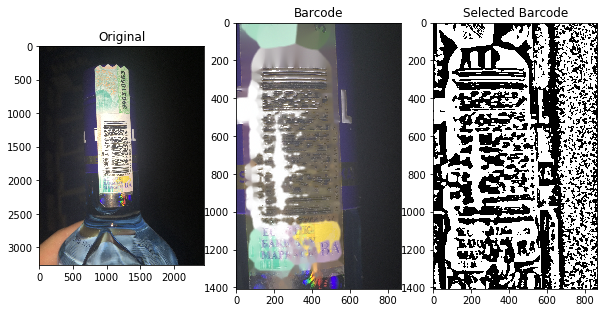

In [12]:
fig = plt.figure(figsize=(10, 200))
build_segmentation_row(filescount, current_file_index, fig, excise_src, telea, barcode_thresholded)
plt.show()

## Try detect

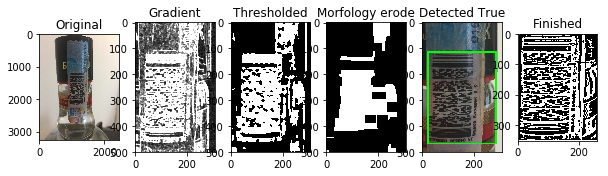

In [166]:
def detect(image_src, row_num, row_count, fig=None, save2file=False, save_dir=''):
    
    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.1.jpg'), image_src)
    else:
        a = fig.add_subplot(row_count, 6, 6 * row_num + 1)
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
        a.set_title('Original')
    
    resized = imutils.resize(image_src[880:880+1408, 828:828+868], height=500)
    # gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
 
    # CLAHE
    hsv_image = cv2.cvtColor(resized, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    gray = clahe.apply(v)
    
    # gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction
    gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)

    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.medianBlur(gradient, 5)
    
    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.2.jpg'), gradient)
    else:
        a = fig.add_subplot(row_count, 6, 6 * row_num + 2)
        plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB))
        a.set_title('Gradient')
    
    # blurred = cv2.bilateralFilter(gradient, 9, 75, 75)
    blurred = cv2.medianBlur(gradient, 11)
    # blurred = cv2.blur(gradient, (5, 5))
    # blurred = cv2.fastNlMeansDenoising(gradient, None, 9, 21)
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.3.jpg'), thresh)
    else:
        a = fig.add_subplot(row_count, 6, 6 * row_num + 3)
        plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB))
        a.set_title('Thresholded')
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # if save2file:
    #    cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.3.jpg'), closed)
    # else:
    #    a = fig.add_subplot(row_count, 5, 5 * row_num + 3)
    #    plt.imshow(cv2.cvtColor(closed, cv2.COLOR_GRAY2RGB))
    #    a.set_title('Morfology closed')
    
    morph = cv2.erode(closed, None, iterations = 11)
    # morph = cv2.dilate(morph, None, iterations = 3)

    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.4.jpg'), morph)
    else:
        a = fig.add_subplot(row_count, 6, 6 * row_num + 4)
        plt.imshow(cv2.cvtColor(morph, cv2.COLOR_GRAY2RGB))
        a.set_title('Morfology erode')
    
    cnts = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    detected = False
    x, y, w, h = 0, 0, 0, 0
    if len(cnts):
        # for c in cnts:
        c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        (x, y, w, h) = cv2.boundingRect(c)
        # PDF417 correction
        x = x - 10 if (x > 10) else 0
        w = w + 20 if (w < 868 - x - 20) else 868 - x
        # Top and bottom black line in PDF417
        y = y - (int)(0.3 * h) if (y > 0.3 * h) else 0
        h = h + (int)(0.5 * h) if (h < 1408 - y - (int)(0.6 * h)) else 1408 - y        
        cv2.rectangle(resized, (x, y), (x + w, y + h), (0, 255, 0), 5)
        detected = True

    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.5.jpg'), resized)
    else:
        a = fig.add_subplot(row_count, 6, 6 * row_num + 5)
        plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        a.set_title('Detected ' + str(detected))

    if detected:
        hsv_image = cv2.cvtColor(resized[y:y+h, x:x+w], cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_image)
        gray = clahe.apply(v)
        blured = cv2.medianBlur(gray, 3)
        finished = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 1)
    
        if save2file:
            cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.6.jpg'), finished)
        else:
            a = fig.add_subplot(row_count, 6, 6 * row_num + 6)
            plt.imshow(cv2.cvtColor(finished, cv2.COLOR_GRAY2RGB))
            a.set_title('Finished')
    
    return gradient, thresh, closed, morph, resized

fig = plt.figure(figsize=(10, 200))
file_src = cv2.imread("test_data/premasked/IMG_0549.JPG")
# file_src = cv2.imread("test_data/premasked/IMG_0806.JPG")
detect(file_src, 0, 1, fig)

plt.show()

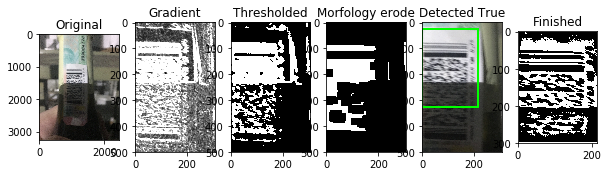

In [147]:
fig = plt.figure(figsize=(10, 200))
file_src = cv2.imread("test_data/premasked/IMG_0799.JPG")
detect(file_src, 0, 1, fig)

plt.show()

100%|██████████| 74/74 [00:52<00:00,  1.26it/s]


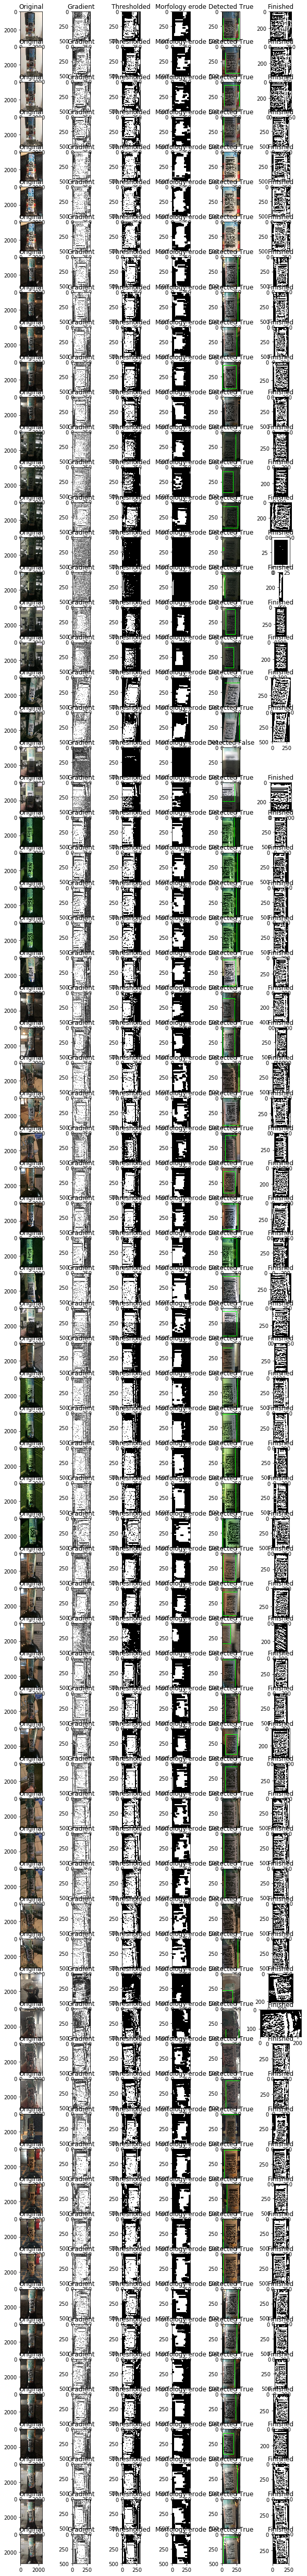

In [148]:
DIR = 'test_data/premasked'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".JPG") or name.endswith(".jpg"))])
current_file_index = 0
fig = plt.figure(figsize=(10, 90))

for filename in tqdm(os.listdir(DIR)):
    if not (filename.endswith(".JPG") or filename.endswith(".jpg")):
        continue
        
    file_src = cv2.imread(os.path.join(DIR, filename))
    detect(file_src, current_file_index, filescount, fig)
    current_file_index += 1
    
plt.show()

In [149]:
DIR = 'data/premasked'
OUTPUT_DIR = 'data/premasked/barcodes'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".JPG") or name.endswith(".jpg"))])
current_file_index = 0

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

for filename in tqdm(os.listdir(DIR)):
    if not (filename.endswith(".JPG") or filename.endswith(".jpg")):
        continue
        
    file_src = cv2.imread(os.path.join(DIR, filename))
    detect(file_src, current_file_index, filescount, fig=None, save2file=True, save_dir=OUTPUT_DIR)
    current_file_index += 1

100%|██████████| 265/265 [01:57<00:00,  2.30it/s]
